# EEG motor imagery classification using ICA
#### Author - Alon Ben-Arieh
In this project we've used ICA to extract valuable information from EEG signals.

The main stages of the projects are:
1. Apply ICA on the data
2. Use Naive Bayes classifiers to find which ICs are meaningful and informative.
3. Reconstruct the electrodes data only from the informative ICs.
4. Feed Igor's CNN with the reconstructed data.

The project was done under the supervision of Miri Binyamini.

In [2]:
from datetime import date
import numpy as np
import mne as mne
import matplotlib.pyplot as plt

# Define constants
ELECTRODES_NUM = 35

# Define data import and export folders paths
today = date.today().strftime("%b-%d-%Y")
month = date.today().strftime("%B")
root_folder = f"data/{month}/{today}"
matlab_data_folder = "data/reut-matlab"

In [4]:
# Fetch the data from the .set file
base_removed_eeglab_epochs = mne.io.read_epochs_eeglab(matlab_data_folder + '/base_removed_short_35_electrodes_filtered_epoched_locations.set')
eeglab_epochs = mne.io.read_epochs_eeglab(matlab_data_folder + '/short_35_electrodes_filtered_epoched_locations.set')

# Trim the data
trimmed_base_removed_eeglab_epochs = base_removed_eeglab_epochs.copy().crop(tmin=0.1, tmax=0.8)
trimmed_eeglab_epochs = eeglab_epochs.copy().crop(tmin=0.1, tmax=0.8)

# Create the train set and test set
total_num_of_epochs = len(eeglab_epochs)

train_set_indexes = []
test_set_indexes = []
for i in range(total_num_of_epochs):
    random_num = np.random.rand()
    if (random_num < 0.8):  # 80% chance of being here
        train_set_indexes.append(i)
    else:
        test_set_indexes.append(i)

train_set = trimmed_eeglab_epochs[train_set_indexes]
test_set = trimmed_eeglab_epochs[test_set_indexes]
base_removed_train_set = trimmed_base_removed_eeglab_epochs[train_set_indexes]
base_removed_test_set = trimmed_base_removed_eeglab_epochs[test_set_indexes]

print(f"Total number of Epochs: {total_num_of_epochs}")
print(f"Train set size: {len(train_set)}. Left: {len(train_set['Left'].selection)} Right: {len(train_set['Right'].selection)} No Move: {len(train_set['NoMove'].selection)}")
print(f"Test set size: {len(test_set)}. Left: {len(test_set['Left'].selection)} Right: {len(test_set['Right'].selection)} No Move: {len(test_set['NoMove'].selection)}")

Extracting parameters from c:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\reut-matlab\base_removed_short_35_electrodes_filtered_epoched_locations.set...
Not setting metadata
440 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from c:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\reut-matlab\short_35_electrodes_filtered_epoched_locations.set...
Not setting metadata
440 matching events found
No baseline correction applied
0 projection items activated
Ready.
Total number of Epochs: 440
Train set size: 366. Left: 111 Right: 129 No Move: 126
Test set size: 74. Left: 27 Right: 24 No Move: 23


In [5]:
# Fit ICA on trimmed data
ica = mne.preprocessing.ICA(n_components = ELECTRODES_NUM, method='picard')
ica.fit(train_set)

Fitting ICA to data using 35 channels (please be patient, this may take a while)


C:\Users\alonb\AppData\Local\Temp\ipykernel_1696\3802390698.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(train_set)


Selecting by number: 35 components
Fitting ICA took 21.1s.


Method,picard
Fit,147 iterations on epochs (128466 samples)
ICA components,35
Explained variance,100.0 %
Available PCA components,35
Channel types,eeg
ICA components marked for exclusion,—


In [6]:
# Export the data
# mne.export.export_epochs(root_folder + '/train_set.set', train_set, overwrite=True)
# mne.export.export_epochs(root_folder + '/test_set.set', test_set, overwrite=True)
mne.export.export_epochs(root_folder + '/base_removed_train_set.set', base_removed_train_set, overwrite=True)
mne.export.export_epochs(root_folder + '/base_removed_test_set.set', base_removed_test_set, overwrite=True)
# mne.export.export_epochs(root_folder + '/trimmed_base_removed_train_set.set', trimmed_base_removed_train_set, overwrite=True)
# # mne.export.export_epochs(root_folder + '/trimmed_base_removed_test_set.set', trimmed_base_removed_test_set, overwrite=True)

In [ ]:
# # Import the data
# train_set = mne.io.read_epochs_eeglab(root_folder + '/train_set.set')
# test_set = mne.io.read_epochs_eeglab(root_folder + '/test_set.set')
base_removed_train_set = mne.io.read_epochs_eeglab(root_folder + '/base_removed_train_set.set')
base_removed_test_set = mne.io.read_epochs_eeglab(root_folder + '/base_removed_test_set.set')
# trimmed_base_removed_train_set = mne.io.read_epochs_eeglab(root_folder + '/trimmed_base_removed_train_set.set')
# trimmed_base_removed_test_set = mne.io.read_epochs_eeglab(root_folder + '/trimmed_base_removed_test_set.set')
# ica = mne.preprocessing.read_ica(root_folder + '/ica.fif')

In [7]:
obj_train_ICs = ica.get_sources(base_removed_train_set)
obj_test_ICs = ica.get_sources(base_removed_test_set)

train_data = np.swapaxes(obj_train_ICs.copy().get_data(), 0, 1)
test_data = np.swapaxes(obj_test_ICs.copy().get_data(), 0, 1)

train_labels = obj_train_ICs.events[:,2]
test_labels = obj_test_ICs.events[:,2]

# train_ICs_left_data = obj_train_ICs['Left'].get_data()
# train_ICs_right_data = obj_train_ICs['Right'].get_data()
# train_ICs_no_move_data = obj_train_ICs['NoMove'].get_data()
# train_ICs_sorted_data = np.swapaxes(np.concatenate([train_ICs_left_data, train_ICs_right_data, train_ICs_no_move_data]),0,1)
# train_labels = [1] * train_ICs_left_data.shape[0] + [2] * train_ICs_right_data.shape[0] + [3]  * train_ICs_no_move_data.shape[0]

# test_ICs_left_data = obj_test_ICs['Left'].get_data()
# test_ICs_right_data = obj_test_ICs['Right'].get_data()
# test_ICs_no_move_data = obj_test_ICs['NoMove'].get_data()
# test_ICs_sorted_data = np.swapaxes(np.concatenate([test_ICs_left_data, test_ICs_right_data, test_ICs_no_move_data]),0,1)
# test_labels = [1] * test_ICs_left_data.shape[0] + [2] * test_ICs_right_data.shape[0] + [3]  * test_ICs_no_move_data.shape[0]

The average accuracy is 0.385.
The average F1 score is 0.377.


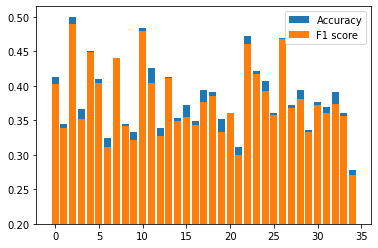

In [8]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score


f1_scores = []
accuracy_scores = []
predictions = []
for i in range(ELECTRODES_NUM):
    # clf = GaussianNB()
    # clf = SVC()
    clf = KNeighborsClassifier(n_neighbors=10)
    predictions.append(cross_val_predict(clf, train_data[i], train_labels))
    f1_scores.append(cross_val_score(clf, train_data[i], train_labels, scoring='f1_macro').mean())
    accuracy_scores.append(cross_val_score(clf, train_data[i], train_labels).mean())
    # predictions.append(cross_val_predict(clf, complete_X[i], complete_Y))
    # f1_scores.append(cross_val_score(clf, complete_X[i], complete_Y, scoring='f1_macro').mean())
    # accuracy_scores.append(cross_val_score(clf, complete_X[i], complete_Y).mean())
    # accuracy_scores.append(accuracy_score(complete_Y, predictions[-1]))
    # f1_scores.append(f1_score(complete_Y, predictions[-1], average='macro'))    
    
f1_scores = np.array(f1_scores)
accuracy_scores = np.array(accuracy_scores)
print(f"The average accuracy is {round(accuracy_scores.mean(),3)}.")
print(f"The average F1 score is {round(f1_scores.mean(),3)}.")

bottom = 0.2
x = np.arange(ELECTRODES_NUM)
plt.bar(x, accuracy_scores-bottom, bottom=bottom, label="Accuracy")
plt.bar(x, f1_scores-bottom, bottom=bottom, label="F1 score")
plt.legend();

# for i in range(ELECTRODES_NUM):
#     ConfusionMatrixDisplay.from_predictions(complete_Y,predictions[i])

In [11]:
acc_thresh = 0.45
f1_thresh = acc_thresh - 0.02
chosen_idxs_by_acc = np.where(accuracy_scores > acc_thresh)
chosen_idxs_by_f1 = np.where(f1_scores > f1_thresh)
chosen_idxs = tuple(np.intersect1d(chosen_idxs_by_acc, chosen_idxs_by_f1))
print(chosen_idxs)

reconstructed_from_best_train_ICs = ica.apply(base_removed_train_set.copy(), include=chosen_idxs)
reconstructed_from_best_test_ICs = ica.apply(base_removed_test_set.copy(), include=chosen_idxs)
mne.export.export_epochs(root_folder + '/reconstructed_from_best_train_ICs.set', reconstructed_from_best_train_ICs, overwrite=True)
mne.export.export_epochs(root_folder + '/reconstructed_from_best_test_ICs.set', reconstructed_from_best_test_ICs, overwrite=True)

(2, 4, 10, 22, 26)
Applying ICA to Epochs instance
    Transforming to ICA space (35 components)
    Zeroing out 30 ICA components
    Projecting back using 35 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (35 components)
    Zeroing out 30 ICA components
    Projecting back using 35 PCA components
Overwriting existing file.
Overwriting existing file.


The average accuracy is 0.43.
The average F1 score is 0.421.


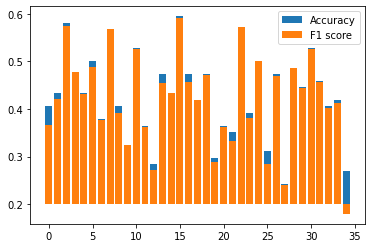

In [12]:
from sklearn.metrics import accuracy_score, f1_score

eval_f1_scores = []
eval_accuracy_scores = []
for i in range(ELECTRODES_NUM):
    # clf = SVC()
    clf = GaussianNB()
    clf.fit(train_data[i], train_labels)
    prediction = clf.predict(test_data[i])
    eval_accuracy_scores.append(accuracy_score(test_labels, prediction))
    eval_f1_scores.append(f1_score(test_labels, prediction, average='macro'))
    # ConfusionMatrixDisplay.from_predictions(test_labels, prediction)
    # print(f"{classification_report(test_labels, prediction)}\n")

eval_f1_scores = np.array(eval_f1_scores) 
eval_accuracy_scores = np.array(eval_accuracy_scores) 
print(f"The average accuracy is {round(eval_accuracy_scores.mean(),3)}.")
print(f"The average F1 score is {round(eval_f1_scores.mean(),3)}.")
bottom = 0.2
x = np.arange(ELECTRODES_NUM)
plt.bar(x, eval_accuracy_scores-bottom, bottom=bottom, label="Accuracy")
plt.bar(x, eval_f1_scores-bottom, bottom=bottom, label="F1 score")
plt.legend();

In [ ]:
time_axis = reconstructed_from_best_train_ICs.times * 1000
channel_names = [['C3'], ['C1'], ['Cz'], ['C2'], ['C4']]
# channel_name = ['C3']
for channel_name in channel_names:
    fig, ax = plt.subplots(nrows = 1, ncols = 1, constrained_layout = True)
    fig.suptitle(f"{channel_name[0]} - ICs {chosen_idxs}", fontsize = 16)
    ax.plot(time_axis, np.squeeze(reconstructed_from_best_train_ICs["Left"].average().pick_channels(channel_name).get_data()), label='Left')
    ax.plot(time_axis, np.squeeze(reconstructed_from_best_train_ICs["Right"].average().pick_channels(channel_name).get_data()), label='Right')
    ax.plot(time_axis, np.squeeze(reconstructed_from_best_train_ICs["NoMove"].average().pick_channels(channel_name).get_data()), label='No Movement')
    ax.legend()